# Imports

In [22]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [23]:
np.random.seed(31071967)

In [24]:
# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# sanity check
project_config["TKL"]

'NVDA'

# Download TKL data from YF

In [26]:
from datetime import date, timedelta
end_date = date.today() - timedelta(days=1)
start_date = end_date - timedelta(days=int(project_config["HISTORY_DEPTH"]))

In [27]:
tickers_yf = {
    "y_today"     : f"{project_config['TKL']}",
    "NASDAQ"      : "^IXIC",
    "SP500"       : "^GSPC",
    "RealEstate"  : "VNQ",
    "Oil_WTI"     : "CL=F",
    "Gold"        : "GC=F"
}

tickers_fred = {
    "Inflation_CPI" : "CPIAUCSL",
    #"Unemployment"  : "UNRATE"
}

In [28]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

# ---- DOWNLOAD FROM YAHOO FINANCE ----
ts_yf = yf.download(
    tickers=list(tickers_yf.values()),
    start=start_date,
    end=end_date,
    auto_adjust=True
)["Close"]

# rename columns to readable names
rename_map = {v: k for k, v in tickers_yf.items()}
ts_yf = ts_yf.rename(columns=rename_map)

# ---- DOWNLOAD FROM FRED ----
import pandas_datareader.data as web
ts_fred = pd.DataFrame()
for col_name, fred_code in tickers_fred.items():
    ts_fred[col_name] = web.DataReader(
        fred_code,
        "fred",
        start_date,
        end_date)

# ---- MERGE ALL ----
tkl_ts = pd.concat([ts_yf, ts_fred], axis=1)

# Fill missing daily values for macro data (monthly)
tkl_ts = tkl_ts.ffill()   # forward fill
tkl_ts = tkl_ts.dropna()  # drop any remaining rows

tkl_ts = tkl_ts.reset_index().rename(columns={"index": "Date"})

display(tkl_ts.head(1))
display(tkl_ts.tail(1))

[*********************100%***********************]  6 of 6 completed


,Date,Oil_WTI,Gold,y_today,RealEstate,SP500,NASDAQ,Inflation_CPI
0,2006-11-01,58.709999,616.599976,0.491729,33.993214,1367.810059,2334.350098,202.0


,Date,Oil_WTI,Gold,y_today,RealEstate,SP500,NASDAQ,Inflation_CPI
4887,2025-12-05,60.080002,4212.899902,182.410004,89.879997,6870.399902,23578.130859,324.368


# Turn time series into supprvied learning table

In [29]:
lags = [1,5,10,22,65] # lookback days
windows =  [5,10,22,65] # statistics windows

df = tkl_ts.copy()

# Identify columns to generate features for (excluding 'index' column which is the date)
feature_base_cols = [c for c in df.columns if c not in ['Date']]

for base_col in feature_base_cols: # Iterate over TKL cols

  # Generate lagged features for the current base_col
  for lag in lags:
    df[f"{base_col}_lag_{lag}"] = df[base_col].shift(lag)

  # Generate rolling window statistics for the current base_col
  for window in windows:
    df[f"{base_col}_min_{window}"] = df[base_col].rolling(window=window).min()
    df[f"{base_col}_max_{window}"] = df[base_col].rolling(window=window).max()
    df[f"{base_col}_mean_{window}"] = df[base_col].rolling(window=window).mean()
    df[f"{base_col}_std_{window}"]  = df[base_col].rolling(window=window).std()
    df[f"{base_col}_diff_{window}"] = df[base_col].diff(window)
    df[f"{base_col}_pct_{window}"] = df[base_col].pct_change(window)


df['y_tomorrow'] = df['y_today'].shift(-1)    # tomorrow's close price
df.tail(1)['y_tomorrow'] = -1                 # the TARGET cell

df.dropna(inplace=True)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

cols_to_scale = df.drop(['Date', 'y_tomorrow'], axis=1).columns
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

df.tail(1)

,Date,Oil_WTI,Gold,y_today,RealEstate,SP500,NASDAQ,Inflation_CPI,Oil_WTI_lag_1,Oil_WTI_lag_5,...,Inflation_CPI_std_22,Inflation_CPI_diff_22,Inflation_CPI_pct_22,Inflation_CPI_min_65,Inflation_CPI_max_65,Inflation_CPI_mean_65,Inflation_CPI_std_65,Inflation_CPI_diff_65,Inflation_CPI_pct_65,y_tomorrow
4886,2025-12-04,0.531927,0.966322,0.885697,0.887359,0.994566,0.980021,1.0,0.52799,0.52635,...,0.0,0.531933,0.591391,1.0,1.0,1.0,0.0,0.460643,0.521173,182.410004


# Split

In [30]:
tommorw_date = df.tail(1)['Date'] # Changed 'Date' to 'index'

X = df.drop(['Date','y_tomorrow'], axis=1) # Changed 'Date' to 'index'
y = df['y_tomorrow']

X_train, X_test = X.iloc[:-2], X.iloc[-1:]
y_train, y_test = y.iloc[:-2], y.iloc[-1:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4820, 210), (1, 210), (4820,), (1,))

# Train, Predict, Evaluate

In [31]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror")

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [32]:
pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print("MAE:", mae)

MAE: 2.3776702880859375


In [33]:
last_row = X_test # Use X_test which was successfully predicted upon
tomorrow_prediction = xgb.predict(last_row)[0]
#tomorrow_prediction_original_value = scaler.inverse_transform(tomorrow_prediction)
print(f"Stoke: {project_config['TKL']}")
print(f"Date: {tommorw_date.iloc[0].date()}")
print(f"Close Prediction: ${tomorrow_prediction:.2f}")

Stoke: NVDA
Date: 2025-12-04
Close Prediction: $180.03


# Feature selection

<Figure size 1000x600 with 0 Axes>

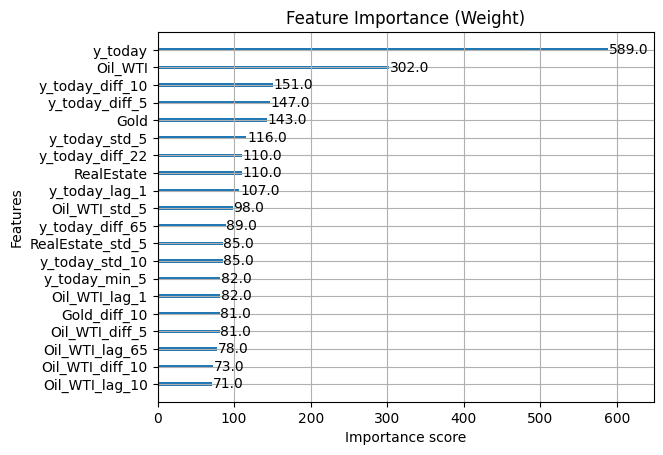

['y_today', 'Oil_WTI', 'y_today_diff_10', 'y_today_diff_5', 'Gold', 'y_today_std_5', 'y_today_diff_22', 'RealEstate', 'y_today_lag_1', 'Oil_WTI_std_5', 'y_today_diff_65', 'y_today_std_10', 'RealEstate_std_5', 'Oil_WTI_lag_1', 'y_today_min_5']


In [34]:
import matplotlib.pyplot as plt
import xgboost # Import the xgboost module

# Plot feature importance based on "weight" (number of times a feature appears in a tree)
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Weight)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='weight')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_weight_features_list = df_importance['Feature'].head(15).tolist()
print(top_weight_features_list)

<Figure size 1000x600 with 0 Axes>

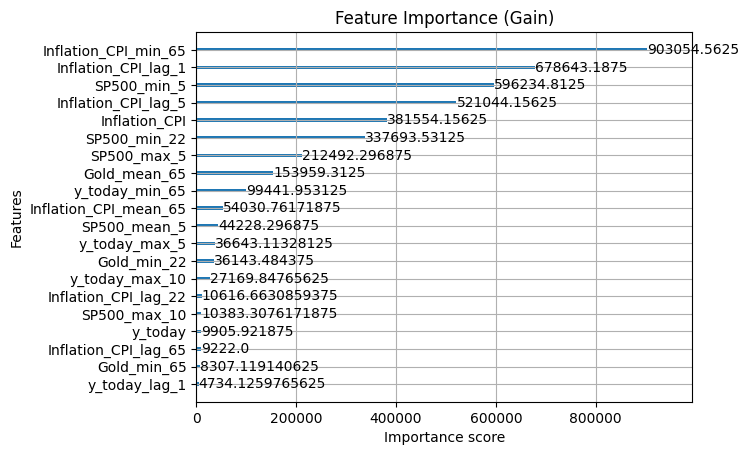

['Inflation_CPI_min_65', 'Inflation_CPI_lag_1', 'SP500_min_5', 'Inflation_CPI_lag_5', 'Inflation_CPI', 'SP500_min_22', 'SP500_max_5', 'Gold_mean_65', 'y_today_min_65', 'Inflation_CPI_mean_65', 'SP500_mean_5', 'y_today_max_5', 'Gold_min_22', 'y_today_max_10', 'Inflation_CPI_lag_22']


In [35]:
# OPTIONAL: Plot based on "gain" (average gain of splits which use the feature)
# "Gain" is often more accurate for finding what actually drives the prediction.
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, importance_type='gain', max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Gain)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='gain')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_gain_features_list = df_importance['Feature'].head(15).tolist()
print(top_gain_features_list)

In [36]:
top_features = list(set(top_gain_features_list) | set(top_weight_features_list))
top_features

['y_today_max_10',
 'Gold',
 'y_today_diff_5',
 'Inflation_CPI',
 'y_today_diff_22',
 'y_today',
 'SP500_max_5',
 'Inflation_CPI_lag_5',
 'RealEstate_std_5',
 'SP500_mean_5',
 'Oil_WTI_lag_1',
 'Gold_mean_65',
 'y_today_min_65',
 'Inflation_CPI_mean_65',
 'y_today_lag_1',
 'Inflation_CPI_lag_22',
 'Inflation_CPI_min_65',
 'SP500_min_22',
 'Inflation_CPI_lag_1',
 'RealEstate',
 'Gold_min_22',
 'y_today_diff_65',
 'y_today_std_10',
 'y_today_diff_10',
 'y_today_std_5',
 'y_today_min_5',
 'Oil_WTI',
 'Oil_WTI_std_5',
 'SP500_min_5',
 'y_today_max_5']

# Final df

In [37]:
final_df = df[['Date','y_tomorrow','y_today'] + top_features]
final_df

,Date,y_tomorrow,y_today,y_today_max_10,Gold,y_today_diff_5,Inflation_CPI,y_today_diff_22,y_today,SP500_max_5,...,Gold_min_22,y_today_diff_65,y_today_std_10,y_today_diff_10,y_today_std_5,y_today_min_5,Oil_WTI,Oil_WTI_std_5,SP500_min_5,y_today_max_5
65,2007-02-05,0.512205,0.001737,0.001586,0.003838,0.466802,0.0,0.410862,0.001737,0.119054,...,0.000000,0.418661,0.000957,0.490083,0.000861,0.001658,0.526842,0.030999,0.122407,0.001638
66,2007-02-06,0.532222,0.001822,0.001633,0.004568,0.466975,0.0,0.411137,0.001822,0.119054,...,0.000000,0.418830,0.001235,0.490384,0.001328,0.001658,0.527608,0.023953,0.123940,0.001723
67,2007-02-07,0.525346,0.001919,0.001730,0.004217,0.467408,0.0,0.411880,0.001919,0.119318,...,0.000778,0.418913,0.001703,0.490468,0.001747,0.001688,0.521211,0.026505,0.125193,0.001819
68,2007-02-08,0.498911,0.001886,0.001730,0.005757,0.467152,0.0,0.411734,0.001886,0.119318,...,0.002004,0.418735,0.001968,0.490653,0.001495,0.001750,0.532145,0.024415,0.125363,0.001819
69,2007-02-09,0.509913,0.001758,0.001730,0.008325,0.466378,0.0,0.411511,0.001758,0.119318,...,0.002004,0.418458,0.001957,0.490265,0.001244,0.001789,0.533129,0.030378,0.123910,0.001819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4882,2025-11-28,179.909988,0.854812,0.918449,0.968078,0.393515,1.0,0.083542,0.854812,0.993234,...,1.000000,0.393085,0.355154,0.319933,0.172045,0.880385,0.525804,0.011305,0.964309,0.881625
4883,2025-12-01,181.449905,0.868925,0.901192,0.973755,0.486882,1.0,0.041353,0.868925,0.993234,...,1.000000,0.465133,0.271020,0.313208,0.171989,0.880385,0.530013,0.015622,0.980927,0.881625
4884,2025-12-02,179.580002,0.876368,0.900805,0.959510,0.444388,1.0,0.119042,0.876368,0.993234,...,1.000000,0.477587,0.221259,0.401323,0.144222,0.880385,0.526296,0.015230,0.990813,0.876356
4885,2025-12-03,183.380005,0.867330,0.900805,0.962943,0.501446,1.0,0.098971,0.867330,0.993336,...,1.000000,0.489957,0.221730,0.459433,0.128908,0.880385,0.527990,0.008580,0.998417,0.876356


In [38]:
view_df = final_df.copy()
# scaler.inverse_transform returns a numpy array, so .values is not needed.
# If you intend to view the data as a DataFrame with original columns, consider removing .reshape(-1, 1) as well.
view_df = scaler.inverse_transform(df.drop(['Date','y_tomorrow'], axis=1))
display(view_df)

array([[5.87400017e+01, 6.50900024e+02, 4.94632274e-01, ...,
        6.68131045e-01, 2.22600000e+00, 1.10198020e-02],
       [5.88800011e+01, 6.53599976e+02, 5.12205243e-01, ...,
        6.76836019e-01, 2.22600000e+00, 1.10198020e-02],
       [5.77099991e+01, 6.52299988e+02, 5.32222211e-01, ...,
        6.83690465e-01, 2.22600000e+00, 1.10198020e-02],
       ...,
       [5.86399994e+01, 4.18660010e+03, 1.81449905e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.89500008e+01, 4.19929980e+03, 1.79580002e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.96699982e+01, 4.21179980e+03, 1.83380005e+02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

# Pickle, CSV

In [39]:
df_pickle_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df.pkl"
df_csv_path = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"

final_df.to_pickle(df_pickle_path)
final_df.to_csv(df_csv_path)